In [3]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os
import gc

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce



from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold



#### 2.1.1- Import the data

In [4]:
path = '/home/ralph/Documents/UDACITY/Machine_Learning/Capstone Project/Data/all/'
out_path = '/home/ralph/Documents/UDACITY/Machine_Learning/Capstone Project/output/'

## IMport all tables that were created in Jupyter 1, 2 e 3

In [5]:
info_train_aux_merge = pd.read_csv(out_path+"info_train_aux_merge.csv")
target = info_train_aux_merge['TARGET']
info_train_aux_merge = info_train_aux_merge.drop(columns = 'TARGET')

info_test_aux_merge = pd.read_csv(out_path+"info_test_aux_merge.csv") 



app_train_bureau_cons_missing = pd.read_csv(out_path+"app_train_bureau_cons_missing.csv") 
app_train_bureau_cons_missing = app_train_bureau_cons_missing.drop(columns = 'TARGET')

app_test_bureau_cons_missing = pd.read_csv(out_path+"app_test_bureau_cons_missing.csv") 



app_train_corr_missing = pd.read_csv(out_path+"app_train_corr_missing.csv") 
app_train_corr_missing = app_train_corr_missing.drop(columns = 'TARGET')

app_test_corr_missing = pd.read_csv(out_path+"app_test_corr_missing.csv") 

In [6]:
app_train_corr_missing.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,ANNUITY_INCOME_PERC,PAYMENT_RATE,1
0,100002,0,0,1,0,202500.0,406597.5,0.018801,9461,-637.0,...,0,0,0,0,1,0,0,0.121978,0.060749,1.0
1,100003,0,0,0,0,270000.0,1293502.5,0.003541,16765,-1188.0,...,0,0,0,0,0,0,0,0.132217,0.027598,1.0
2,100004,1,1,1,0,67500.0,135000.0,0.010032,19046,-225.0,...,0,0,0,0,0,0,0,0.100000,0.050000,1.0
3,100006,0,0,1,0,135000.0,312682.5,0.008019,19005,-3039.0,...,0,0,0,0,0,0,0,0.219900,0.094941,1.0
4,100007,0,0,1,0,121500.0,513000.0,0.028663,19932,-3038.0,...,0,0,0,0,0,0,0,0.179963,0.042623,1.0


 ## Make only one data frame for train and test

In [7]:
data_frames_Train = [app_train_corr_missing,info_train_aux_merge,app_train_bureau_cons_missing]

In [17]:
tb_train_homecredit = reduce(lambda  left,right: pd.merge(left,right,on=['SK_ID_CURR'],
                                            how='left'), data_frames_Train)

In [9]:
tb_train_homecredit.shape

(307511, 362)

In [18]:
data_frames_Test = [app_test_corr_missing,info_test_aux_merge,app_test_bureau_cons_missing]
tb_test_homecredit = reduce(lambda  left,right: pd.merge(left,right,on=['SK_ID_CURR'],
                                            how='left'), data_frames_Test)

In [11]:
tb_test_homecredit.shape

(48744, 362)

In [19]:
tb_train_homecredit, tb_test_homecredit = tb_train_homecredit.align(tb_test_homecredit, join = 'inner', axis = 1)

tb_train_homecredit['TARGET'] = target

# Print out the new shapes
print('Training data with polynomial features shape: ', tb_train_homecredit.shape)
print('Testing data with polynomial features shape:  ', tb_test_homecredit.shape)


Training data with polynomial features shape:  (307511, 363)
Testing data with polynomial features shape:   (48744, 362)


### removing correlated variables

In [20]:

# Threshold for removing correlated variables
threshold = 0.6
 
tb_train_homecredit =tb_train_homecredit.drop(columns = ['TARGET'])
# Absolute value correlation matrix
corr_matrix = tb_train_homecredit.corr().abs()
corr_matrix.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Unknown type of loan_count,STATUS_1_count,STATUS_2_count,STATUS_2_count_norm,STATUS_4_count,STATUS_5_count,STATUS_C_count
SK_ID_CURR,1.000000,0.001654,0.001216,0.000703,0.001129,0.001820,0.000343,0.000849,0.001500,0.000084,...,0.001265,0.001514,0.000575,0.000026,0.000599,NaN,NaN,0.000238,0.002336,0.002394
NAME_CONTRACT_TYPE,0.001654,1.000000,0.004022,0.067177,0.029998,0.003531,0.221648,0.026867,0.086364,0.036388,...,0.000628,0.013743,0.005342,0.002595,0.005273,NaN,NaN,0.001584,0.001561,0.017185
FLAG_OWN_CAR,0.001216,0.004022,1.000000,0.002817,0.102023,0.083383,0.116225,0.041314,0.129879,0.023096,...,0.002665,0.051768,0.004253,0.000917,0.001195,NaN,NaN,0.004223,0.001509,0.005722
FLAG_OWN_REALTY,0.000703,0.067177,0.002817,1.000000,0.002366,0.002934,0.039270,0.015175,0.119146,0.030665,...,0.001305,0.015031,0.000990,0.005637,0.003384,NaN,NaN,0.001361,0.001571,0.001784
CNT_CHILDREN,0.001129,0.029998,0.102023,0.002366,1.000000,0.012882,0.002145,0.025573,0.330938,0.061145,...,0.004229,0.092384,0.004620,0.002993,0.003041,NaN,NaN,0.001226,0.000110,0.000028


In [21]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Unknown type of loan_count,STATUS_1_count,STATUS_2_count,STATUS_2_count_norm,STATUS_4_count,STATUS_5_count,STATUS_C_count
SK_ID_CURR,NaN,0.001654,0.001216,0.000703,0.001129,0.001820,0.000343,0.000849,0.001500,0.000084,...,0.001265,0.001514,0.000575,0.000026,0.000599,NaN,NaN,0.000238,0.002336,0.002394
NAME_CONTRACT_TYPE,NaN,NaN,0.004022,0.067177,0.029998,0.003531,0.221648,0.026867,0.086364,0.036388,...,0.000628,0.013743,0.005342,0.002595,0.005273,NaN,NaN,0.001584,0.001561,0.017185
FLAG_OWN_CAR,NaN,NaN,NaN,0.002817,0.102023,0.083383,0.116225,0.041314,0.129879,0.023096,...,0.002665,0.051768,0.004253,0.000917,0.001195,NaN,NaN,0.004223,0.001509,0.005722
FLAG_OWN_REALTY,NaN,NaN,NaN,NaN,0.002366,0.002934,0.039270,0.015175,0.119146,0.030665,...,0.001305,0.015031,0.000990,0.005637,0.003384,NaN,NaN,0.001361,0.001571,0.001784
CNT_CHILDREN,NaN,NaN,NaN,NaN,NaN,0.012882,0.002145,0.025573,0.330938,0.061145,...,0.004229,0.092384,0.004620,0.002993,0.003041,NaN,NaN,0.001226,0.000110,0.000028


In [22]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 0 columns to remove.


In [23]:

tb_train_homecredit = tb_train_homecredit.drop(columns = to_drop)
tb_test_homecredit = tb_test_homecredit.drop(columns = to_drop)

print('Training shape: ', tb_train_homecredit.shape)
print('Testing shape: ', tb_test_homecredit.shape)

Training shape:  (307511, 362)
Testing shape:  (48744, 362)


In [24]:

# Train missing values (in percent)
train_missing = (tb_train_homecredit.isnull().sum() / len(tb_train_homecredit)).sort_values(ascending = False)
train_missing.head()


LANDAREA_AVG                          0.593767
NONLIVINGAREA_AVG                     0.551792
APARTMENTS_AVG                        0.507497
YEARS_BEGINEXPLUATATION_AVG           0.487810
bureau_AMT_CREDIT_MAX_OVERDUE_mean    0.402018
dtype: float64

In [25]:

# Test missing values (in percent)
test_missing = (tb_test_homecredit.isnull().sum() / len(tb_test_homecredit)).sort_values(ascending = False)
test_missing.head()


LANDAREA_AVG                          0.579641
NONLIVINGAREA_AVG                     0.535122
APARTMENTS_AVG                        0.490050
YEARS_BEGINEXPLUATATION_AVG           0.468899
bureau_AMT_CREDIT_MAX_OVERDUE_mean    0.403311
dtype: float64

In [26]:
train_missing_ = train_missing.index[train_missing > 0.60]

test_missing_  = test_missing.index[test_missing > 0.60]

all_missing = list(set(set(train_missing_)|set(test_missing_)))

In [47]:
tb_train_homecredit = tb_train_homecredit.drop(columns = all_missing)
tb_test_homecredit = tb_test_homecredit.drop(columns = all_missing)

In [27]:
print('Training set full shape: ', info_train_aux_merge.shape)
print('Testing set full shape: ' , info_test_aux_merge.shape)

Training set full shape:  (307511, 141)
Testing set full shape:  (48744, 141)


In [28]:

# Align the dataframes
tb_train_homecredit, tb_test_homecredit = tb_train_homecredit.align(tb_test_homecredit, join = 'inner', axis = 1)

tb_train_homecredit['TARGET'] = target

# Print out the new shapes
print('Training data with polynomial features shape: ', tb_train_homecredit.shape)
print('Testing data with polynomial features shape:  ', tb_test_homecredit.shape)


Training data with polynomial features shape:  (307511, 363)
Testing data with polynomial features shape:   (48744, 362)


In [29]:
tb_train_homecredit.to_csv(out_path+"tb_train_homecredit.csv", index=False)

In [30]:
tb_test_homecredit.to_csv(out_path+"tb_test_homecredit.csv", index=False)

In [33]:
tb_test_homecredit.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Unknown type of loan_count,STATUS_1_count,STATUS_2_count,STATUS_2_count_norm,STATUS_4_count,STATUS_5_count,STATUS_C_count
0,100001,0,0,1,0,135000.0,568800.0,0.018850,19241,-2329.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0,0,1,0,99000.0,222768.0,0.035792,18064,-4469.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100013,0,1,1,0,202500.0,663264.0,0.019101,20038,-4458.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100028,0,0,1,2,315000.0,1575000.0,0.026392,13976,-1866.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100038,0,1,0,1,180000.0,625500.0,0.010032,13040,-2191.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Killing kernel memory needed

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os
import gc

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce



from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
path = '/home/ralph/Documents/UDACITY/Machine_Learning/Capstone Project/Data/all/'
out_path = '/home/ralph/Documents/UDACITY/Machine_Learning/Capstone Project/output/'

In [3]:
tb_train_homecredit = pd.read_csv(out_path+"tb_train_homecredit.csv")

In [4]:
tb_train_homecredit.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Unknown type of loan_count,STATUS_1_count,STATUS_2_count,STATUS_2_count_norm,STATUS_4_count,STATUS_5_count,STATUS_C_count,TARGET
0,100002,0,0,1,0,202500.0,406597.5,0.018801,9461,-637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,100003,0,0,0,0,270000.0,1293502.5,0.003541,16765,-1188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100004,1,1,1,0,67500.0,135000.0,0.010032,19046,-225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,100006,0,0,1,0,135000.0,312682.5,0.008019,19005,-3039.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,0,0,1,0,121500.0,513000.0,0.028663,19932,-3038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [5]:
target = tb_train_homecredit['TARGET']

In [6]:
tb_test_homecredit = pd.read_csv(out_path+"tb_test_homecredit.csv")

In [7]:
tb_test_homecredit.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Unknown type of loan_count,STATUS_1_count,STATUS_2_count,STATUS_2_count_norm,STATUS_4_count,STATUS_5_count,STATUS_C_count
0,100001,0,0,1,0,135000.0,568800.0,0.018850,19241,-2329.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0,0,1,0,99000.0,222768.0,0.035792,18064,-4469.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100013,0,1,1,0,202500.0,663264.0,0.019101,20038,-4458.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100028,0,0,1,2,315000.0,1575000.0,0.026392,13976,-1866.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100038,0,1,0,1,180000.0,625500.0,0.010032,13040,-2191.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Ajustando a tabela para fazer as importancias das features
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in tb_train_homecredit:
    train = tb_train_homecredit.drop(columns = ['TARGET'])
else:
    train = tb_train_homecredit.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = tb_test_homecredit.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)



Training data shape:  (307511, 362)
Testing data shape:  (48744, 362)


In [9]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, target)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [10]:
log_reg.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)>

In [11]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [12]:
submit = tb_test_homecredit[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.065857
1,100005,0.135970
2,100013,0.068615
3,100028,0.077845
4,100038,0.136104


In [12]:
#submission  = '/home/ralph/Documents/UDACITY/Machine_Learning/Capstone Project/'
#submit.to_csv(submission+'log_reg_baseline_full.csv', index = False)

In [13]:
pd.DataFrame(tb_train_homecredit).head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Unknown type of loan_count,STATUS_1_count,STATUS_2_count,STATUS_2_count_norm,STATUS_4_count,STATUS_5_count,STATUS_C_count,TARGET
0,100002,0,0,1,0,202500.0,406597.5,0.018801,9461,-637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,100003,0,0,0,0,270000.0,1293502.5,0.003541,16765,-1188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100004,1,1,1,0,67500.0,135000.0,0.010032,19046,-225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,100006,0,0,1,0,135000.0,312682.5,0.008019,19005,-3039.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,0,0,1,0,121500.0,513000.0,0.028663,19932,-3038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [14]:

from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)	


# Train on the training data
random_forest.fit(train, target)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


In [15]:

def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:16]))), 
            df['importance_normalized'].head(16), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:16]))))
    ax.set_yticklabels(df['feature'].head(16))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

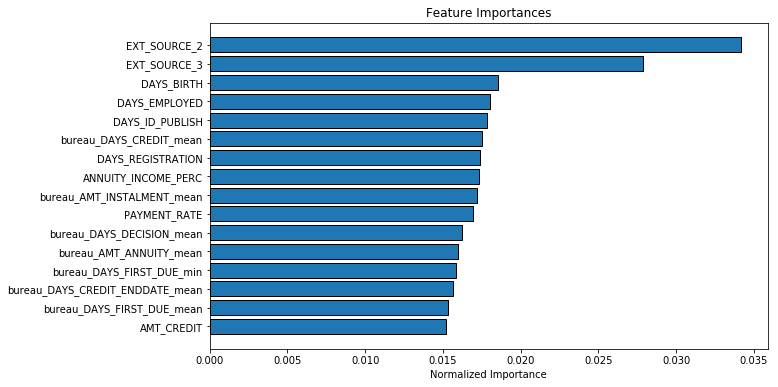

In [16]:
feature_importances_sorted = plot_feature_importances(feature_importances[1:])


In [17]:
# Feature names
features = list(tb_train_homecredit.columns)
features

['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'LANDAREA_AVG',
 'NONLIVINGAREA_AVG',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_

# Light GBM default paramter

In [24]:
folds = KFold(n_splits=2, shuffle=True, random_state=1001)

In [25]:
tb_train_homecredit = pd.read_csv(out_path+"tb_train_homecredit.csv")
target = tb_train_homecredit['TARGET']

In [26]:
tb_train_homecredit.shape

(307511, 363)

In [27]:
tb_test_homecredit = pd.read_csv(out_path+"tb_test_homecredit.csv")

In [28]:
# Divide in training/validation and test data
train_df = tb_train_homecredit.copy()
test_df = tb_test_homecredit.copy()
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))


Starting LightGBM. Train shape: (307511, 363), test shape: (48744, 362)


In [30]:
# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
sub_preds_ = np.zeros(train_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [31]:
# Iterate through each fold
for train_indices, valid_indices in folds.split(train_df[feats],train_df['TARGET']):
        
    # Training data for the fold
    train_features, train_labels = train_df[feats].iloc[train_indices], train_df['TARGET'].iloc[train_indices]
    # Validation data for the fold
    valid_features, valid_labels = train_df[feats].iloc[valid_indices], train_df['TARGET'].iloc[valid_indices]
        
    # Create the model
    #model = LGBMClassifier(n_estimators=5000, objective = 'binary',
                           # class_weight = 'balanced', learning_rate = 0.05,
                           # reg_alpha = 0.1, reg_lambda = 0.1, 
                            #subsample = 0.8, n_jobs = -1, random_state = 50)
    
    
    model = LGBMClassifier()
    
        
    # Train the model
    model.fit(train_features, train_labels, eval_metric = 'auc',
                eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                eval_names = ['valid', 'train'],
                early_stopping_rounds = 100, verbose = 200)
    
    oof_preds[valid_indices] = model.predict_proba(valid_features, num_iteration=model.best_iteration_)[:, 1]
    sub_preds += model.predict_proba(test_df[feats], num_iteration=model.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = model.feature_importances_
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del model, train_features, train_labels, valid_features, valid_labels
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	train's binary_logloss: 0.218368	train's auc: 0.839091	valid's binary_logloss: 0.245356	valid's auc: 0.767278
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	train's binary_logloss: 0.220797	train's auc: 0.840192	valid's binary_logloss: 0.242525	valid's auc: 0.76448
Full AUC score 0.765845


In [32]:
fold_importance_df.shape

(361, 2)

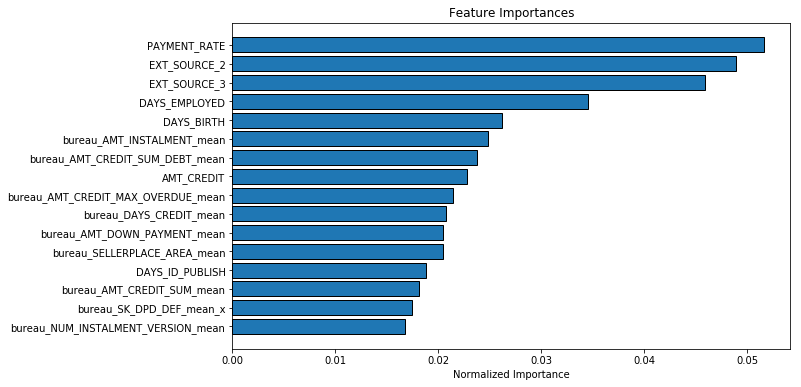

In [34]:
feature_importances_sorted = plot_feature_importances(fold_importance_df[1:])

In [31]:
#test_df['TARGET'] = sub_preds
#submission = test_df[['SK_ID_CURR', 'TARGET']]
#submission.to_csv(out_path+'submissionv2.csv', index= False)

In [35]:
# Iterate through each fold
for train_indices, valid_indices in folds.split(train_df[feats],train_df['TARGET']):
        
    # Training data for the fold
    train_features, train_labels = train_df[feats].iloc[train_indices], train_df['TARGET'].iloc[train_indices]
    # Validation data for the fold
    valid_features, valid_labels = train_df[feats].iloc[valid_indices], train_df['TARGET'].iloc[valid_indices]
        
    # Create the model
    model = LGBMClassifier(n_estimators=5000, objective = 'binary',
                           class_weight = 'balanced', learning_rate = 0.05,
                           reg_alpha = 0.1, reg_lambda = 0.1,
                           subsample = 0.8, n_jobs = -1, random_state = 50)
    
    
    #model = LGBMClassifier()
    
        
    # Train the model
    model.fit(train_features, train_labels, eval_metric = 'auc',
                eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                eval_names = ['valid', 'train'],
                early_stopping_rounds = 100, verbose = 200)
    
    oof_preds[valid_indices] = model.predict_proba(valid_features, num_iteration=model.best_iteration_)[:, 1]
    sub_preds += model.predict_proba(test_df[feats], num_iteration=model.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = model.feature_importances_
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del model, train_features, train_labels, valid_features, valid_labels
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.51483	train's auc: 0.83365	valid's binary_logloss: 0.537873	valid's auc: 0.769233
Early stopping, best iteration is:
[221]	train's binary_logloss: 0.50884	train's auc: 0.839536	valid's binary_logloss: 0.534059	valid's auc: 0.769486
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.511964	train's auc: 0.836433	valid's binary_logloss: 0.538285	valid's auc: 0.767728
Early stopping, best iteration is:
[223]	train's binary_logloss: 0.505468	train's auc: 0.842672	valid's binary_logloss: 0.534144	valid's auc: 0.767901
Full AUC score 0.768697


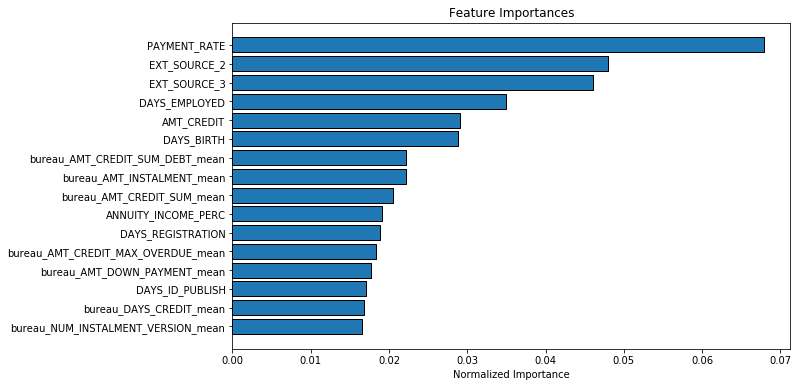

In [36]:
feature_importances_sorted = plot_feature_importances(fold_importance_df[1:])